In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
import cace
from cace.representations.cace_representation import Cace

In [5]:
from ase.io import read,write

In [6]:
sys_list = {
"CC": 0,
"CA": 2,
"PA": 3,
"CP": 4,
"PP": 5,
"AA": 6,
}

In [7]:
def get_RMSE(true, pred):
    return np.sqrt(np.mean((true-pred)**2.))

In [8]:
sys_now = 'CC-r5-q1'
tag = '0'

In [9]:
train_xyz_dir = './lode-datasets/train-id'+tag+'.xyz'
test_xyz_dir = './lode-datasets/test-id'+tag+'.xyz'

In [10]:
train_ase_xyz = read(train_xyz_dir, ':')
test_ase_xyz = read(test_xyz_dir, ':')

In [11]:
device = cace.tools.init_device('cpu')

In [12]:
evaluator = cace.tasks.EvaluateTask(model_path='fit-lode-'+sys_now+'/model-tmp.pth', device='cpu',
                                    energy_key='CACE_energy', #'ewald_potential',
                                    forces_key='CACE_forces',
                                    )

In [13]:
model_now = torch.load('fit-lode-'+sys_now+'/model-tmp.pth')

In [14]:
evaluator = cace.tasks.EvaluateTask(model_path='fit-lode-'+sys_now+'/model-tmp.pth', device='cpu',
                                    energy_key='CACE_energy',
                                    forces_key='CACE_forces',
                                    )

In [15]:
evaluator_sr = cace.tasks.EvaluateTask(model_path='fit-lode-CC-sr/model-tmp.pth', device='cpu',
                                    energy_key='CACE_energy', #'ewald_potential',
                                    forces_key='CACE_forces',
                                    )

In [16]:
pred_train = evaluator(train_ase_xyz)
pred_test = evaluator(test_ase_xyz)

In [17]:
pred_train_sr = evaluator_sr(train_ase_xyz)
pred_test_sr = evaluator_sr(test_ase_xyz)

In [18]:
train_f_true  = np.array([ xyz.get_array('forces') for xyz in train_ase_xyz]).reshape(-1,3)
test_f_true  = np.array([ xyz.get_array('forces') for xyz in test_ase_xyz]).reshape(-1,3)

In [19]:
def get_property(atoms, info_name):
    return np.array([a.info[info_name] for a in atoms])

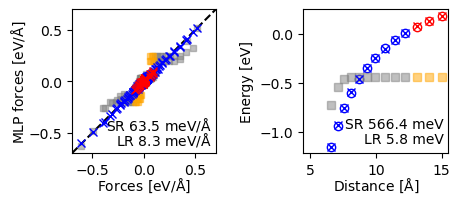

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(4.7, 2.2), width_ratios=[1,1])
plt.subplots_adjust(hspace=0.0)

ax1=ax[0]

ax1.plot(np.arange(-1,2), np.arange(-1,2), 'k--')
ax1.plot(train_f_true[:,0], pred_train_sr['forces'][:,0], 's', color='gray', alpha=0.5, ms=4,label='Train SR')

ax1.plot(test_f_true[:,0], pred_test_sr['forces'][:,0], 's', color='orange', alpha=0.5, ms=4, label='Test SR')

ax1.plot(train_f_true[:,0], pred_train['forces'][:,0], 'x', color='blue', label='Train LR')

ax1.plot(test_f_true[:,0], pred_test['forces'][:,0], 'x', color='red', label='Test LR')

ax1.set_aspect('equal', adjustable='box')

ax1.set_xlabel('Forces [eV/$\mathrm{\AA}$]', labelpad=-1)

ax1.set_ylabel('MLP forces [eV/$\mathrm{\AA}$]', labelpad=-0)

#legend = ax1.legend(frameon=True, ncol=2, bbox_to_anchor=(1, -0.35), handletextpad=0.1, columnspacing=0.1,)
#ax1.legend(frameon=False, ncol=1, handletextpad=0.1, columnspacing=0.1)

ax1.text(0.97, 0.2,  
    'SR '+"{:.1f}".format(get_RMSE(test_f_true[:,0], pred_test_sr['forces'][:,0])*1000.)+' meV/$\mathrm{\AA}$',
     horizontalalignment='right',
     verticalalignment='center',
     transform = ax1.transAxes)

ax1.text(0.97, 0.1,  
    'LR '+"{:.1f}".format(get_RMSE(test_f_true[:,0], pred_test['forces'][:,0])*1000.)+' meV/$\mathrm{\AA}$',
     horizontalalignment='right',
     verticalalignment='center',
     transform = ax1.transAxes)

fm=0.7
ax1.set_xlim([-fm, fm])
ax1.set_ylim([-fm, fm])



ax1=ax[1]

# Upper panel
ax1.plot(get_property(train_ase_xyz, 'distance'), get_property(train_ase_xyz, 'inter_energy'), 
         'o',color='blue', markerfacecolor='white', label='True train')
ax1.plot(get_property(test_ase_xyz, 'distance'), get_property(test_ase_xyz, 'inter_energy'), 
         'o',color='red', markerfacecolor='white', label='True test')

ax1.plot(get_property(train_ase_xyz, 'distance'), pred_train_sr['energy'], 's', color='gray', alpha=0.5, label='SR train')
ax1.plot(get_property(test_ase_xyz, 'distance'), pred_test_sr['energy'], 's', color='orange', alpha=0.5, label='SR test')

ax1.plot(get_property(train_ase_xyz, 'distance'), pred_train['energy'], 'x', color='b', label='LR train')
ax1.plot(get_property(test_ase_xyz, 'distance'), pred_test['energy'], 'x', color='r', label='LR test')
#ax1.set_title('Energy')
ax1.set_xlabel('Distance [$\mathrm{\AA}$]',labelpad=-1)

ax1.set_ylabel('Energy [eV]')

ax1.set_xlim([4.5, 15.5])

ax1.text(0.97, 0.2,  
    'SR '+"{:.1f}".format(get_RMSE(get_property(test_ase_xyz, 'inter_energy'), pred_test_sr['energy'])*1000.)+' meV',
     horizontalalignment='right',
     verticalalignment='center',
     transform = ax1.transAxes)

ax1.text(0.97, 0.1,  
    'LR '+"{:.1f}".format(get_RMSE(get_property(test_ase_xyz, 'inter_energy'), pred_test['energy'])*1000.)+' meV',
     horizontalalignment='right',
     verticalalignment='center',
     transform = ax1.transAxes)

#tablelegend(ax1, ncol=3, bbox_to_anchor=(1, 1), 
#            row_labels=['Train', 'Test'], 
#            col_labels=['True', 'SR', 'LR'])

#legend = ax1.legend(frameon=False, ncol=6, bbox_to_anchor=(1, -0.35), handletextpad=0.1, columnspacing=0.1,)

plt.tight_layout()
plt.show()


fig.savefig('compare-'+sys_now+'.pdf', dpi=300)

In [21]:
def export_legend(legend, filename="legend-2.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)
export_legend(legend)